In [9]:
import pandas as pd
import numpy as np
import os
import os.path
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, KFold
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Lasso, LogisticRegression, LassoCV
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import bootstrap
from src.utils.data import getDataPandas, getConfig
from pipe.lut import Model_LUT, Metrics_LUT, Feature_LUT, Plot_LUT
from pipe.stats import stats_analyze
from mrmr import mrmr_classif, mrmr_regression

In [3]:
# None-image features
data = getDataPandas()
model_config = getConfig('model')
data_config = getConfig('data')
img_config = getConfig('image')
group = data_config['data_group']

# Tasks include models used
TASKS = [
    #'classification/5',
    #'regression',
    'classification/2',
    'logistic/2'
]
# Features include image features used
FEATURES = [
    ['tiv_gmv', 't1_radiomic'],
]

# Maybe write to a specific file later?
log_func = print
rst = {}
auc_dist = {}

Current Task: classification/2

Image Features:
 ['tiv_gmv', 't1_radiomic']

SEX chi2 p: 0.5414803876006902
CAT chi2 p: 0.9510706628888684
AGE_AT_VISIT Normaltest p_train: [0.07505303], p_test: [0.48389882]
AGE_AT_VISIT t-test p: Ttest_indResult(statistic=array([1.54953415]), pvalue=array([0.12271054]))
NUPDR3OF Normaltest p_train: [0.01407325], p_test: [0.53859285]
NUPDR3OF ranksums p: RanksumsResult(statistic=array([0.53408144]), pvalue=array([0.59328519]))
LEDD Normaltest p_train: [2.56158925e-12], p_test: [0.1798008]
LEDD ranksums p: RanksumsResult(statistic=array([0.51837316]), pvalue=array([0.60419794]))
DURATION Normaltest p_train: [0.00553476], p_test: [0.13860719]
DURATION ranksums p: RanksumsResult(statistic=array([-0.45554005]), pvalue=array([0.64872076]))



100%|██████████| 50/50 [00:01<00:00, 31.41it/s]


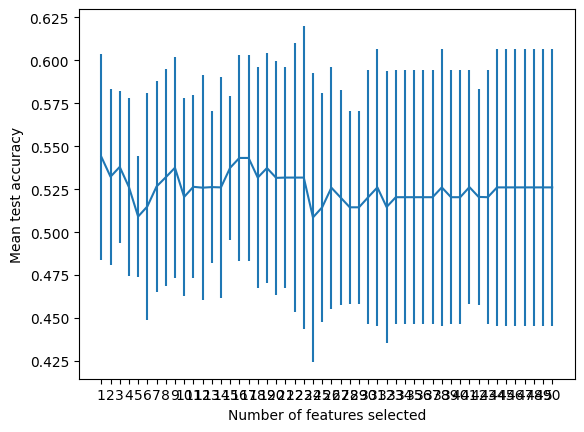

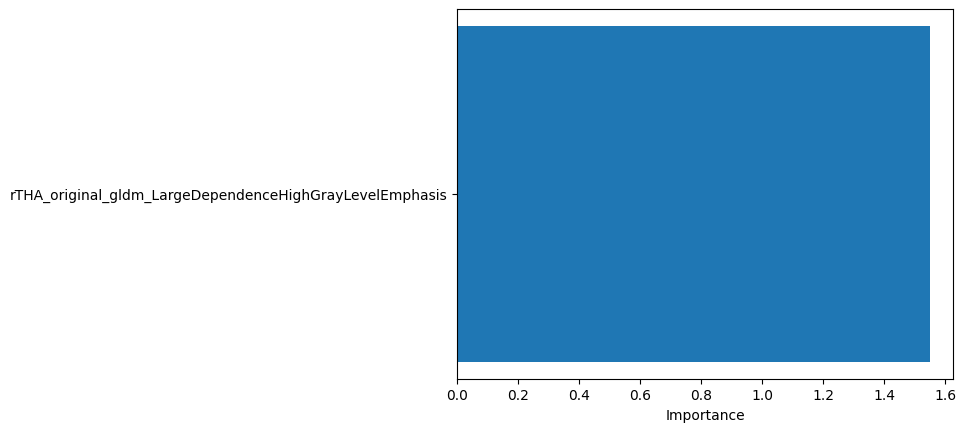

Selected features: ['rTHA_original_gldm_LargeDependenceHighGrayLevelEmphasis']

Demo + Clinic:

Model: svc
AUC train 0.7654370489174017 ci ConfidenceInterval(low=0.6797667659425877, high=0.82968242326408)
AUC test 0.7102272727272727 ci ConfidenceInterval(low=0.5370027498869742, high=0.847207654865799)


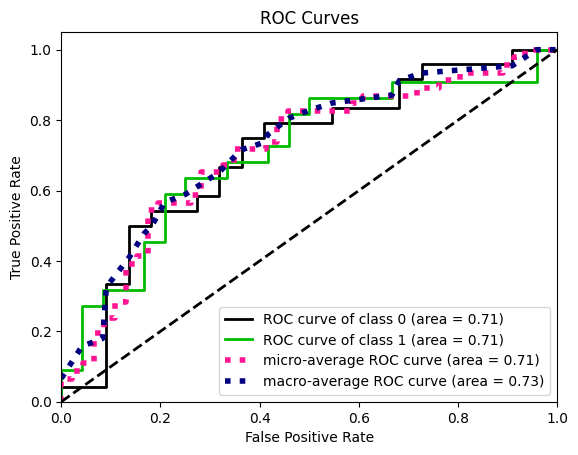

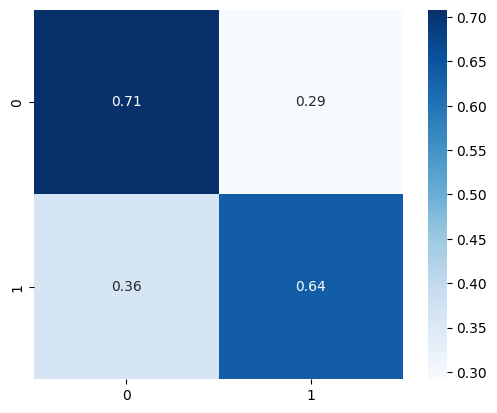

Model: xgboost
AUC train 0.9662523389468057 ci ConfidenceInterval(low=0.9348152760151843, high=0.9836495996769453)
AUC test 0.7462121212121212 ci ConfidenceInterval(low=0.6019529992844715, high=0.8903846153846153)


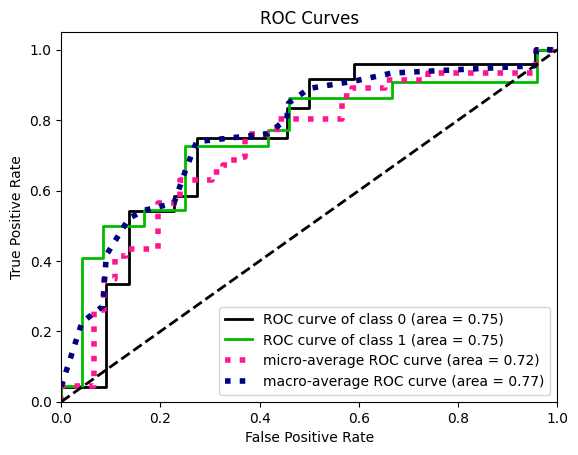

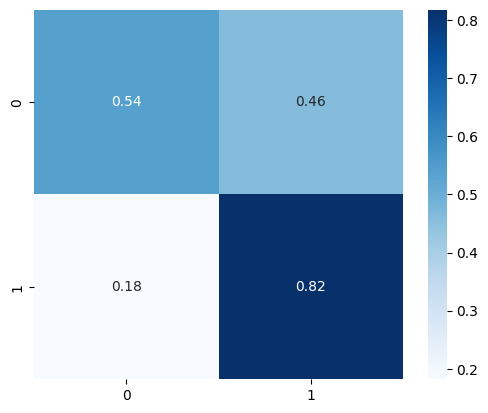


Demo + Clinic + Img:

Model: svc
AUC train 0.8503742314889067 ci ConfidenceInterval(low=0.7834671835212704, high=0.8997579602431017)
AUC test 0.6723484848484848 ci ConfidenceInterval(low=0.5018939393939394, high=0.8323790514537136)


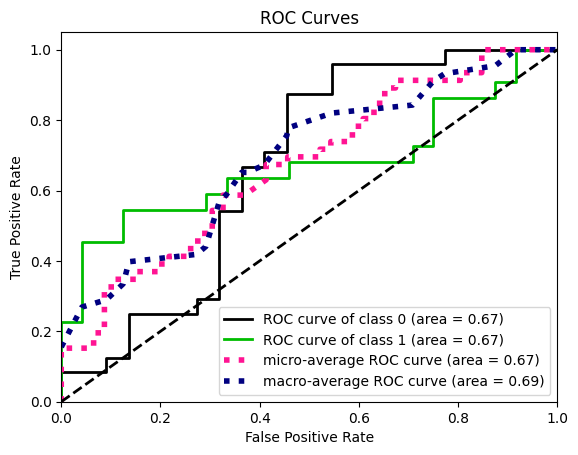

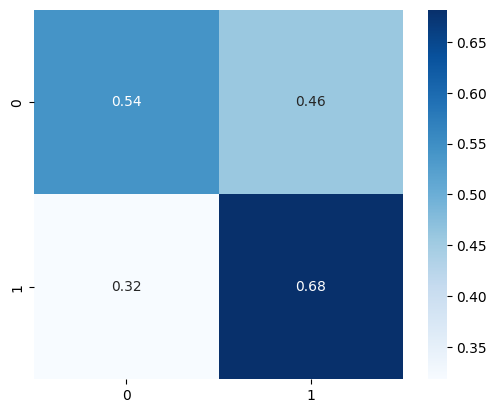

KeyboardInterrupt: 

In [41]:
# Loop for tasks and feature collections
for task_name in TASKS:
    log_func('Current Task: {}'.format(task_name))
    log_func()
    for feature_names in FEATURES:
        log_func('Image Features:\n {}'.format(feature_names))
        log_func()
        # Get model list
        task = model_config['task'][task_name]
        models = task['models']
        metric_list = task['metrics']
        
        # Filter data with demographic and clinical keys
        x = data[group['demo'] + group['clinic']]
        y = data[[task['output']]]
        # Split the dataset
        train_inds = data_config['train_index']
        test_inds = data_config['test_index']
        x_clinic_train = x.iloc[train_inds].reset_index(drop=True)
        x_clinic_test = x.iloc[test_inds].reset_index(drop=True)
        y_train = y.iloc[train_inds].reset_index(drop=True)
        y_test = y.iloc[test_inds].reset_index(drop=True)
        # Statistical Analysis
        stats_analyze(x_clinic_train, x_clinic_test, y_train, y_test, data_config)
        # Empty dataframes to fill with image features
        x_img_train = pd.DataFrame(index=x_clinic_train.index).reset_index(drop=True)
        x_img_test = pd.DataFrame(index=x_clinic_test.index).reset_index(drop=True)

        # Loop to calculate each feature, multiple features are supported
        for feature_name in feature_names:
            # Get calculation function and params via LUT
            func = Feature_LUT[feature_name]
            params = img_config['task'][feature_name]['params']
            # Calculate features and append to the dataframe
            x_fe_train, x_fe_test = func(data, train_inds, test_inds, params)
            x_img_train = x_img_train.join(x_fe_train.reset_index(drop=True))
            x_img_test = x_img_test.join(x_fe_test.reset_index(drop=True))

        # Normalization
        scaler = MinMaxScaler()
        x_img_train = pd.DataFrame(scaler.fit_transform(x_img_train, y_train), columns=x_img_train.columns)
        x_img_test = pd.DataFrame(scaler.transform(x_img_test), columns=x_img_test.columns)
        
        ## Feature Selection
        ## WIP
        
        isContinuous = task['continuous']
        
        ##mRMR
        selected = mrmr_classif(X=x_img_train, y=y_train, K=50) if not isContinuous else mrmr_regression(X=x_img_train, y=y_train, K=50)
        ##LASSO for classification?
        la = LassoCV(cv=5, random_state=1, max_iter=10000)
        la.fit(x_img_train[selected], data['CAT'].iloc[train_inds])
        print(la.alpha_)
        plt.semilogx(la.alphas_, la.mse_path_, ':')
        plt.plot(
            la.alphas_ ,
            la.mse_path_.mean(axis=-1),
            "k",
            label="Average across the folds",
            linewidth=2,
        )
        plt.axvline(
            la.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
        )
        plt.legend()
        plt.ylabel('MSE')
        plt.xlabel('alpha')
        plt.show()
        la = Lasso(alpha=la.alpha_)
        la.fit(x_img_train[selected], data['CAT'].iloc[train_inds])
        selected = np.array(selected)[np.abs(la.coef_)>0]
        coef = np.array(la.coef_)[np.abs(la.coef_)>0]
        sort_idx = coef.argsort()
        plt.barh(selected[sort_idx], coef[sort_idx])
        plt.xlabel('Importance')
        plt.show()
        #selected = selected[:2]
        
        #est = LogisticRegression(penalty='elasticnet', solver='saga', random_state=1, l1_ratio=0.5)
        #est = LogisticRegression(penalty='l1', solver='saga', random_state=1)
        est = LogisticRegression(random_state=1)
        selector = RFECV(est, min_features_to_select=1, cv=5, step=1)
        selector = selector.fit(X=x_img_train[selected], y=y_train)
        selected = np.array(selected)[selector.get_support()]
        n_scores = len(selector.cv_results_["mean_test_score"])
        plt.errorbar(
            range(1, n_scores+1),
            selector.cv_results_["mean_test_score"],
            yerr=selector.cv_results_["std_test_score"],
        )
        plt.xticks(range(1,n_scores+1))
        plt.xlabel("Number of features selected")
        plt.ylabel("Mean test accuracy")
        plt.show()
        coef = selector.estimator_.coef_[0]
        sort_idx = coef.argsort()
        plt.barh(selected[sort_idx], coef[sort_idx])
        plt.xlabel('Importance')
        plt.show()
        #selector = selector.fit(X=x_img_train, y=y_train)
        #selected = np.array(x_img_train.columns)[selector.get_support()]

        
        log_func('Selected features: {}'.format(selected))
        log_func()
        x_img_train = x_img_train[selected]
        x_img_test = x_img_test[selected]

        # Rearrange data
        # demo + clinic, demo + img, demo + clinic + img
        x_clinic_train = x_clinic_train.reset_index(drop=True)
        x_clinic_test = x_clinic_test.reset_index(drop=True)
        x_demo_train = x_clinic_train[group['demo']]
        x_demo_test = x_clinic_test[group['demo']]
        x_clinic_img_train = x_clinic_train.join(x_img_train)
        x_clinic_img_test = x_clinic_test.join(x_img_test)
        # No demo data in img df
        x_img_train = x_demo_train.join(x_img_train)
        x_img_test = x_demo_test.join(x_img_test)

        x_train_list = [x_clinic_train, x_clinic_img_train]
        x_test_list = [x_clinic_test, x_clinic_img_test]
        info_list = ['Demo + Clinic:', 'Demo + Clinic + Img:']
        
        #x_train_list = [x_clinic_img_train]
        #x_test_list = [x_clinic_img_test]
        #info_list = ['Demo + Clinic + Img:']

        # Loop
        for i in range(len(info_list)):
            x_train = x_train_list[i]
            x_test = x_test_list[i]
            scaler = MinMaxScaler()
            x_train = pd.DataFrame(scaler.fit_transform(x_train, y_train), columns=x_train.columns)
            x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)
            log_func(info_list[i])
            log_func()
            for model in models:
                name = model['name']
                parameters = model['params']
                model = Model_LUT[name]
                cv = GridSearchCV(
                    model(),
                    parameters,
                    n_jobs=5,
                    # StratifiedGroupKFold?
                    cv=(StratifiedKFold(n_splits=5, shuffle=True, random_state=1) if task['stratify'] else KFold(n_splits=5, shuffle=True, random_state=1)),
                    scoring=task['gridsearch_params']['scoring']
                )
                cv.fit(x_train, y_train.values.ravel())
                model_instance = model(**cv.best_params_)
                model_instance.fit(x_train, y_train.values.ravel())
                log_func('Model: {}'.format(name))
                # Now classification specific, other metrics need to be considered according to task
                for metric in metric_list:
                    metric_func = Metrics_LUT[metric[0]]
                    # predict_proba True
                    # predic        False
                    pred_func = model_instance.predict_proba if metric[1] else model_instance.predict
                    train_pred = pred_func(x_train)
                    test_pred = pred_func(x_test)
                    
                    # CI
                    from sklearn import metrics
                    y_train_np = y_train[task['output']].to_numpy()
                    y_test_np = y_test[task['output']].to_numpy()
                    ci_train = bootstrap((y_train_np, train_pred[:, 1]), statistic=metrics.roc_auc_score, n_resamples=1000, paired=True, random_state=1)
                    ci_test = bootstrap((y_test_np, test_pred[:, 1]), statistic=metrics.roc_auc_score, n_resamples=1000, paired=True, random_state=1)
                    
                    log_func('{} train {} ci {}'.format(metric[0],
                                                           metric_func(y_train_np, train_pred),
                                                           ci_train.confidence_interval
                                                           ))
                    log_func('{} test {} ci {}'.format(metric[0],
                                                           metric_func(y_test_np, test_pred),
                                                           ci_test.confidence_interval
                                                           ))
                    auc_dist[info_list[i]+name] = ci_test.bootstrap_distribution
                plot_list = task['plot']
                for plot in plot_list:
                    plot_func = Plot_LUT[plot[0]]
                    pred_func = model_instance.predict_proba if plot[1] else model_instance.predict
                    train_pred = pred_func(x_train)
                    test_pred = pred_func(x_test)
                    plot_func(y_test[task['output']].to_numpy(), test_pred)
                    plt.show()
            log_func()

In [34]:
from scipy.stats import ttest_ind
print(ttest_ind(auc_dist['Demo + Clinic + Img:logistic'], auc_dist['Demo + Clinic:logistic'], alternative='greater').pvalue)
print(ttest_ind(auc_dist['Demo + Clinic + Img:svc'], auc_dist['Demo + Clinic:svc'], alternative='greater').pvalue)
print(ttest_ind(auc_dist['Demo + Clinic + Img:xgboost'], auc_dist['Demo + Clinic:xgboost'], alternative='greater').pvalue)

0.011739287980170808
4.765242682745555e-60
1.5845429371873796e-82


In [40]:
len(y_train[y_train['CAT']==1])

86

In [13]:
# Loop for tasks and feature collections
for task_name in TASKS:
    log_func('Current Task: {}'.format(task_name))
    log_func()
    for feature_names in FEATURES:
        log_func('Image Features:\n {}'.format(feature_names))
        log_func()
        # Get model list
        task = model_config['task'][task_name]
        models = task['models']
        metric_list = task['metrics']
        
        # Filter data with demographic and clinical keys
        x = data[group['demo'] + group['clinic']]
        y = data[[task['output']]]
        # Split the dataset
        train_inds = data_config['train_index']
        test_inds = data_config['test_index']
        x_clinic_train = x.iloc[train_inds].reset_index(drop=True)
        x_clinic_test = x.iloc[test_inds].reset_index(drop=True)
        y_train = y.iloc[train_inds].reset_index(drop=True)
        y_test = y.iloc[test_inds].reset_index(drop=True)
        # Statistical Analysis
        stats_analyze(x_clinic_train, x_clinic_test, y_train, y_test, data_config)
        # Empty dataframes to fill with image features
        x_img_train = pd.DataFrame(index=x_clinic_train.index).reset_index(drop=True)
        x_img_test = pd.DataFrame(index=x_clinic_test.index).reset_index(drop=True)

        # Loop to calculate each feature, multiple features are supported
        for feature_name in feature_names:
            # Get calculation function and params via LUT
            func = Feature_LUT[feature_name]
            params = img_config['task'][feature_name]['params']
            # Calculate features and append to the dataframe
            x_fe_train, x_fe_test = func(data, train_inds, test_inds, params)
            x_img_train_full = x_img_train.join(x_fe_train.reset_index(drop=True))
            x_img_test_full = x_img_test.join(x_fe_test.reset_index(drop=True))
            
        # Normalization
        scaler = MinMaxScaler()
        x_img_train_full = pd.DataFrame(scaler.fit_transform(x_img_train_full, y_train), columns=x_img_train_full.columns)
        x_img_test_full = pd.DataFrame(scaler.transform(x_img_test_full), columns=x_img_test_full.columns)

        ## Feature Selection
        ## WIP
        
        isContinuous = task['continuous']
        
        #mRMR
        ranked = mrmr_classif(X=x_img_train_full, y=y_train, K=50) if not isContinuous else mrmr_regression(X=x_img_train_full, y=y_train, K=50)
        
        rst_auc = [[[], []], [[], []]]
        
        for s in range(len(ranked)):
            log_func()
            log_func()
            log_func(s)
            selected = ranked[:s]
            log_func('Selected features: {}'.format(selected))
            log_func()
            x_img_train = x_img_train_full[selected]
            x_img_test = x_img_test_full[selected]

            # Rearrange data
            # demo + clinic, demo + img, demo + clinic + img
            x_clinic_train = x_clinic_train.reset_index(drop=True)
            x_clinic_test = x_clinic_test.reset_index(drop=True)
            x_demo_train = x_clinic_train[group['demo']]
            x_demo_test = x_clinic_test[group['demo']]
            x_clinic_img_train = x_clinic_train.join(x_img_train)
            x_clinic_img_test = x_clinic_test.join(x_img_test)
            # No demo data in img df
            x_img_train = x_demo_train.join(x_img_train)
            x_img_test = x_demo_test.join(x_img_test)

            x_train_list = [x_clinic_img_train]
            x_test_list = [x_clinic_img_test]
            info_list = ['Demo + Clinic + Img:']

            # Loop
            for i in range(1):
                x_train = x_train_list[i]
                x_test = x_test_list[i]
                scaler = MinMaxScaler()
                x_train = pd.DataFrame(scaler.fit_transform(x_train, y_train), columns=x_train.columns)
                x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)
                log_func(info_list[i])
                log_func()
                count = 0
                for model in models:
                    name = model['name']
                    parameters = model['params']
                    model = Model_LUT[name]
                    cv = GridSearchCV(
                        model(),
                        parameters,
                        n_jobs=5,
                        # StratifiedGroupKFold?
                        cv=(StratifiedKFold(n_splits=5, shuffle=True, random_state=1) if task['stratify'] else KFold(n_splits=5, shuffle=True, random_state=1)),
                        scoring=task['gridsearch_params']['scoring']
                    )
                    cv.fit(x_train, y_train.values.ravel())
                    model_instance = model(**cv.best_params_)
                    model_instance.fit(x_train, y_train.values.ravel())
                    log_func('Model: {}'.format(name))
                    # Now classification specific, other metrics need to be considered according to task
                    for metric in metric_list:
                        metric_func = Metrics_LUT[metric[0]]
                        # predict_proba True
                        # predic        False
                        pred_func = model_instance.predict_proba if metric[1] else model_instance.predict
                        train_pred = pred_func(x_train)
                        test_pred = pred_func(x_test)
                        # TODO: multiclass support should be implemented via metric_func
                        log_func('{} train {}, test {}'.format(metric[0],
                                                               metric_func(y_train[task['output']].to_numpy(), train_pred),
                                                               metric_func(y_test[task['output']].to_numpy(), test_pred)
                                                               ))
                        rst_auc[count][0].append(metric_func(y_train[task['output']].to_numpy(), train_pred))
                        rst_auc[count][1].append(metric_func(y_test[task['output']].to_numpy(), test_pred))
                    count += 1

Current Task: classification/2

Image Features:
 ['t1_radiomic']

SEX chi2 p: 0.5414803876006902
CAT chi2 p: 0.9510706628888684
AGE_AT_VISIT Normaltest p_train: [0.07505303], p_test: [0.48389882]
AGE_AT_VISIT t-test p: Ttest_indResult(statistic=array([1.54953415]), pvalue=array([0.12271054]))
NUPDR3OF Normaltest p_train: [0.01407325], p_test: [0.53859285]
NUPDR3OF ranksums p: RanksumsResult(statistic=array([0.53408144]), pvalue=array([0.59328519]))
LEDD Normaltest p_train: [2.56158925e-12], p_test: [0.1798008]
LEDD ranksums p: RanksumsResult(statistic=array([0.51837316]), pvalue=array([0.60419794]))
DURATION Normaltest p_train: [0.00553476], p_test: [0.13860719]
DURATION ranksums p: RanksumsResult(statistic=array([-0.45554005]), pvalue=array([0.64872076]))



100%|██████████| 50/50 [00:02<00:00, 18.34it/s]




0
Selected features: []

Demo + Clinic + Img:

Model: svc
AUC train 0.7654370489174017, test 0.7102272727272727
Model: xgboost
AUC train 0.9662523389468057, test 0.7462121212121212


1
Selected features: ['rTHA_original_gldm_LargeDependenceHighGrayLevelEmphasis']

Demo + Clinic + Img:

Model: svc
AUC train 0.8503742314889067, test 0.6723484848484848
Model: xgboost
AUC train 0.9887730553327987, test 0.7007575757575758


2
Selected features: ['rTHA_original_gldm_LargeDependenceHighGrayLevelEmphasis', 'rRN_original_glszm_SmallAreaLowGrayLevelEmphasis']

Demo + Clinic + Img:

Model: svc
AUC train 0.8277198609997327, test 0.7329545454545454
Model: xgboost
AUC train 0.9395883453622027, test 0.7708333333333333


3
Selected features: ['rTHA_original_gldm_LargeDependenceHighGrayLevelEmphasis', 'rRN_original_glszm_SmallAreaLowGrayLevelEmphasis', 'lCAU_original_glcm_Idn']

Demo + Clinic + Img:

Model: svc
AUC train 0.8205693664795509, test 0.7282196969696969
Model: xgboost
AUC train 0.982624966

In [155]:
idx = np.argmax(rst_auc[0][1])
print(rst_auc[0][0][idx])
print(rst_auc[0][1][idx])
print(ranked[idx])
print(idx)

0.7587543437583534
0.8352272727272728
rCAU_original_gldm_DependenceVariance
31


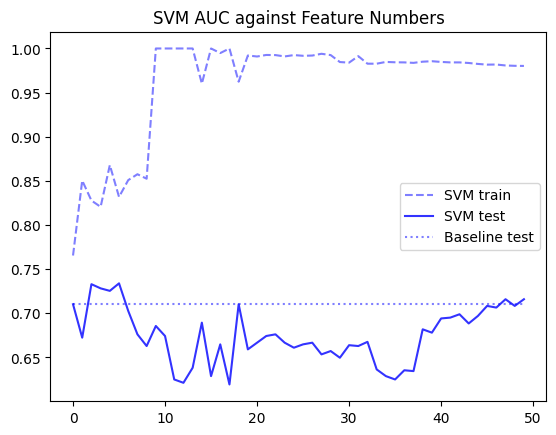

5


In [14]:
plt.plot(rst_auc[0][0], 'b--', alpha=0.5)
plt.plot(rst_auc[0][1], 'b', alpha=0.8)
plt.plot([rst_auc[0][1][0]] * 50, 'b:', alpha=0.5)
plt.legend(['SVM train', 'SVM test', 'Baseline test'])
plt.title('SVM AUC against Feature Numbers')
plt.show()
print(np.argmax(rst_auc[0][1]))

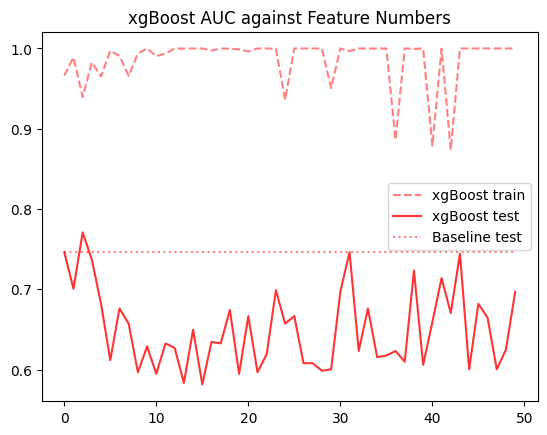

2


In [15]:
plt.plot(rst_auc[1][0], 'r--', alpha=0.5)
plt.plot(rst_auc[1][1], 'r', alpha=0.8)
plt.plot([rst_auc[1][1][0]] * 50, 'r:', alpha=0.5)
plt.legend(['xgBoost train', 'xgBoost test', 'Baseline test'])
plt.title('xgBoost AUC against Feature Numbers')
plt.show()
print(np.argmax(rst_auc[1][1]))

In [12]:
rst_auc[1][1][3]

0.768939393939394